In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.datasets import mnist # for CNN we want the non-flatten mnist dataset
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

## Utility functions

In [119]:
# plot performances
def model_performance(histories_av):
    
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))  
    # plot loss
    ax0.set_title('Cross Entropy Loss')
    ax0.plot(histories_av[0], color='black')
    ax0.plot(histories_av[2], color='red', linestyle='dashed')
    ax0.set_xlabel('Epochs')
    #plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax0.legend(['train', 'validation'], loc='upper right')
    # plot accuracy
    ax1.set_title('Accuracy')
    ax1.plot(histories_av[1], color='black')
    ax1.plot(histories_av[3], color='red', linestyle='dashed')
    ax1.set_xlabel('Epochs')
    #plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    ax1.legend(['train', 'validation'], loc='lower right')

    fig.suptitle('5-fold cross-validation')
    plt.show()

In [3]:
# score
def score(model, testX, testY):
    sco = model.evaluate(
        testX,
        to_categorical(testY)
    )
    result = "This model achieved {:.3f} test loss and {:.2f} % test accuracy".format(sco[0], sco[1]*100)
    return result

## Dataset loading and pre-treatment

In [4]:
(trainX, trainY), (testX, testY) = mnist.load_data()

In [5]:
print(trainX.shape) # (60000, 28, 28)
print(trainY.shape) # (60000,)

(60000, 28, 28)
(60000,)


In [6]:
# Normalizing in the interval [-0.5, 0.5]
trainX = (trainX / 255) - 0.5
testX = (testX / 255) - 0.5

In [7]:
# Reshaping the images (keras expects a 3D array)
trainX = np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)

print(trainX.shape) # (60000, 28, 28, 1)
print(testX.shape)  # (10000, 28, 28, 1)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Model

In [8]:
# reasonable "best" model ?? https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
def define_best_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Conv2D(64, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))


    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

In [9]:
print(define_best_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

## Model evaluation

In [10]:
def evaluate_model(model, dataX, dataY, n_folds=5, epochs=8, verbose=0, batch_size=32):
    histories = list()
    kfold = KFold(n_folds, shuffle=True, random_state=42)
    for train_index, test_index in kfold.split(dataX):
        trainX, testX = dataX[train_index], dataX[test_index]
        trainY, testY = dataY[train_index], dataY[test_index]
        # fit model
        history = model.fit(
            trainX,
            to_categorical(trainY),
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(testX, to_categorical(testY)),
            verbose=verbose
        )
        histories.append(history)
    return histories

In [12]:
histories_best_model = evaluate_model(define_best_model(), trainX, trainY, verbose=2, epochs=10)

Epoch 1/10
1500/1500 - 120s - loss: 0.2355 - accuracy: 0.9263 - val_loss: 0.0545 - val_accuracy: 0.9849
Epoch 2/10
1500/1500 - 120s - loss: 0.0909 - accuracy: 0.9729 - val_loss: 0.0399 - val_accuracy: 0.9879
Epoch 3/10
1500/1500 - 107s - loss: 0.0703 - accuracy: 0.9791 - val_loss: 0.0370 - val_accuracy: 0.9900
Epoch 4/10
1500/1500 - 141s - loss: 0.0602 - accuracy: 0.9811 - val_loss: 0.0360 - val_accuracy: 0.9900
Epoch 5/10
1500/1500 - 136s - loss: 0.0515 - accuracy: 0.9845 - val_loss: 0.0367 - val_accuracy: 0.9891
Epoch 6/10
1500/1500 - 136s - loss: 0.0477 - accuracy: 0.9852 - val_loss: 0.0295 - val_accuracy: 0.9919
Epoch 7/10
1500/1500 - 102s - loss: 0.0459 - accuracy: 0.9857 - val_loss: 0.0271 - val_accuracy: 0.9918
Epoch 8/10
1500/1500 - 116s - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.0290 - val_accuracy: 0.9919
Epoch 9/10
1500/1500 - 107s - loss: 0.0412 - accuracy: 0.9871 - val_loss: 0.0314 - val_accuracy: 0.9918
Epoch 10/10
1500/1500 - 106s - loss: 0.0405 - accuracy: 0.9876 -

## Save evaluation

In [88]:
import json

list_histories = []
for h in histories_best_model:
    list_histories.append(json.dumps(h.history))
    
json.dump(list_histories, open('list_histories.txt', 'w'), indent=4)

## Average over folds

For one history object, h, we can easily access the dictionary with h.history

When dealing with a list of history object as in our case things get complicated because we cannot json-serialize any type of structure containing tensorflow history objects.

The solution is to pass by strings (json.dumps) and then reconvert to dictionaries taking care of all issues related to bad formatting (' instead of ")

In [89]:
with open('list_histories.txt') as json_file:
    data = json.load(json_file)
    
print(type(data))
print(type(data[0]))


<class 'list'>
<class 'str'>


In [126]:
# Average over folds
all_loss = []
all_acc = []
all_val_loss = []
all_val_acc = []
for h in data:
    hj = json.loads(h.replace("'",'"'))
    all_loss.append(hj['loss'])
    all_acc.append(hj['accuracy'])
    all_val_loss.append(hj['val_loss'])
    all_val_acc.append(hj['val_accuracy'])

av_loss = np.mean(np.array(all_loss), axis=0)
av_acc = np.mean(np.array(all_acc), axis=0)
av_val_loss = np.mean(np.array(all_val_loss), axis=0)
av_val_acc = np.mean(np.array(all_val_acc), axis=0)
histories_av = [av_loss, av_acc, av_val_loss, av_val_acc]
print(histories_av)
# pretty ugly...think about a more elegant solution in 40D

[array([0.07441142, 0.04443521, 0.03972556, 0.03681433, 0.03459292,
       0.03360146, 0.03169024, 0.03163478, 0.03128464, 0.03145959]), array([0.97728748, 0.98690834, 0.98833749, 0.98904585, 0.98973333,
       0.98999166, 0.99044584, 0.99077083, 0.99057918, 0.99064583]), array([0.01667102, 0.01393492, 0.01435988, 0.01475912, 0.01526412,
       0.01427984, 0.01405832, 0.01465244, 0.01600939, 0.01424224]), array([0.99525   , 0.99573332, 0.99581667, 0.99551667, 0.99533333,
       0.99578333, 0.9957    , 0.99555   , 0.99508333, 0.99585   ])]


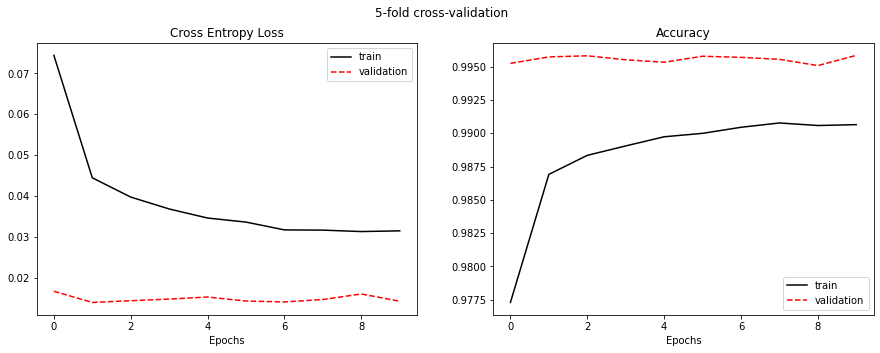

In [120]:
model_performance(histories_av)

In [121]:
final_model = define_best_model()

In [122]:
final_model.fit(
    trainX,
    to_categorical(trainY),
    epochs=10,
    batch_size=32
)

Epoch 1/10
1875/1875 [==============================] - 144s 76ms/step - loss: 0.4452 - accuracy: 0.8566
Epoch 2/10
1875/1875 [==============================] - 132s 71ms/step - loss: 0.0906 - accuracy: 0.9709
Epoch 3/10
1875/1875 [==============================] - 136s 73ms/step - loss: 0.0709 - accuracy: 0.9779
Epoch 4/10
1875/1875 [==============================] - 121s 64ms/step - loss: 0.0574 - accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 121s 65ms/step - loss: 0.0552 - accuracy: 0.9838
Epoch 6/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.0493 - accuracy: 0.9851
Epoch 7/10
1875/1875 [==============================] - 137s 73ms/step - loss: 0.0449 - accuracy: 0.9861
Epoch 8/10
1875/1875 [==============================] - 149s 79ms/step - loss: 0.0393 - accuracy: 0.9878
Epoch 9/10
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0404 - accuracy: 0.9875
Epoch 10/10
1875/1875 [==============================] 

In [127]:
score(final_model, testX, testY)

313/313 [==============================] - 5s 15ms/step - loss: 0.0221 - accuracy: 0.9928


'This model achieved 0.022 test loss and 99.28 % test accuracy'

In [128]:
# Store the predictions
predictions = final_model.predict(testX)
predicted = np.argmax(predictions, axis=1)

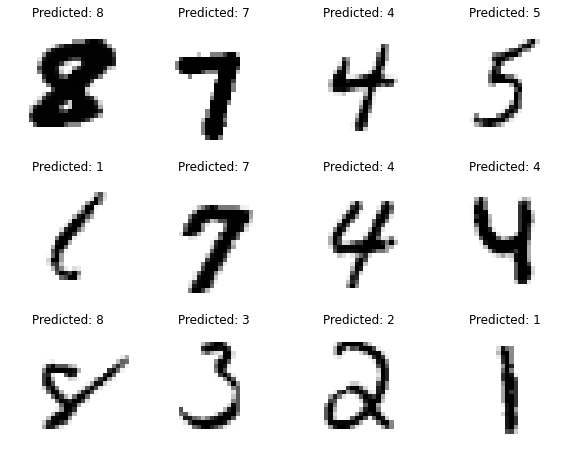

In [129]:
# We randomly pick 12 images
images = testX.reshape((-1, 28, 28))

select = np.random.randint(testX.shape[0], size=12)

fig = plt.figure(figsize=(10,8))
for index, value in enumerate(select):
    fig.add_subplot(3,4,index+1)
    plt.axis('off')
    plt.imshow((images[value]+0.5)*255,cmap=plt.cm.gray_r,interpolation="nearest")
    plt.title('Predicted: {}'.format(predicted[value]))


<AxesSubplot:>

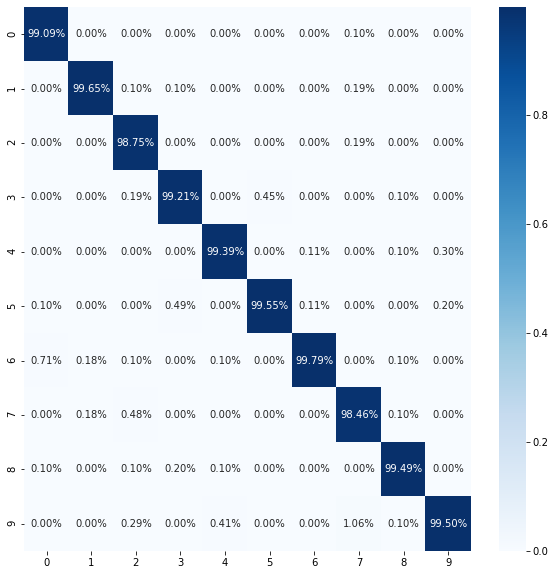

In [130]:
cf_matrix = confusion_matrix(testY, predicted)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')